In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import Calibration as cb
chesspath=r"../data/chessboard.jpg"
chesscampath=r"../data/OpenCVtabletorecognize1.jpeg"
markersX = 9           #X轴上标记的数量
markersY = 6          #EY轴上标记的数量
markerLength = 100#标记的长度，单位是像素
markerSeparation = 0#每个标记之间的间隔，单位像素
margins = markerSeparation #标记与边界之间的间隔
borderBits = 1 #标记的边界所占的bit位数
square_size=10
pattern_size = (markersX, markersY)
width = markersX * (markerLength + markerSeparation) - markerSeparation + 2 * margins
height =markersY * (markerLength + markerSeparation) - markerSeparation + 2 * margins
print(width,height)
def show(img,title="haha"):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()


900 600


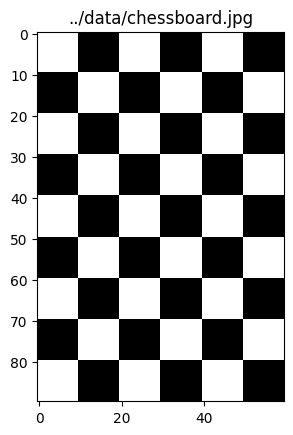

In [8]:
# 生成棋盘格
chessboard = cb.chess.generate_chessboard(pattern_size, square_size)
#cv2.imwrite(chesspath, chessboard)
show(chessboard,chesspath)

In [9]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# print(cv2.TERM_CRITERIA_EPS,'',cv2.TERM_CRITERIA_MAX_ITER)
img = cv2.imread(chesscampath)
# Color-segmentation to get the binary mask
lower_blue = np.array([0, 0, 0], dtype=np.uint8)
upper_blue = np.array([255, 255, 255], dtype=np.uint8)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, lower_blue, upper_blue)
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 1. 调整亮度和对比度以获得更清晰的棋盘格
gray = cv2.convertScaleAbs(gray, alpha=1.5, beta=0)
# 2. 使用自适应阈值化来获得更清晰的棋盘格
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
# 3. 高斯模糊来减少噪声
blur = cv2.GaussianBlur(gray,(5,5),0)
# 4. 调整findChessboardCorners的参数,如改变角点数量,提高质量级别等


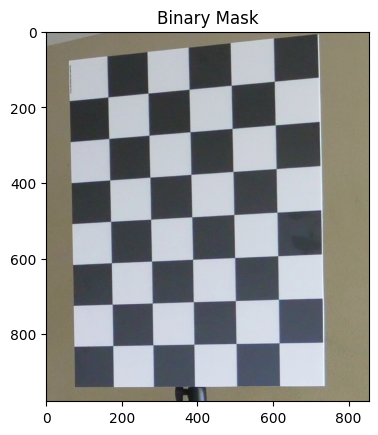

In [10]:
res = cv2.bitwise_and(img, img, mask=mask)
show(res, "Binary Mask")


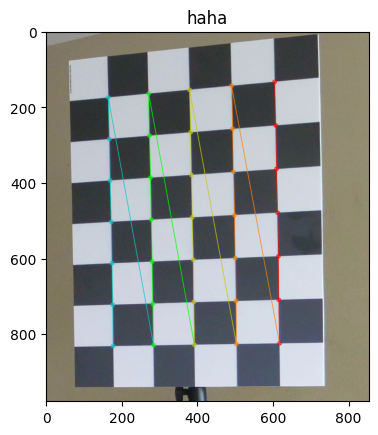

In [11]:
img = cv2.imread(chesscampath)
pattern_size=(7,5)
ret=True
corners=chess.find_corners_sb(img,pattern_size)
# 绘制并显示检测到的角点
cv2.drawChessboardCorners(img, pattern_size, corners, ret)
show(img)



In [12]:
# 如果找到足够点对，将其存储起来
corners3 = np.array([])

if ret == True:
    #精确找到角点坐标
    corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
    corners3 = np.array([corners[0],corners[10],corners[77],corners[87]])
    # 将角点在图像上显示
    cv2.drawChessboardCorners(img, (2,2), corners3, ret)
    print(corners3)
    # cv2.imshow('findCorners',img)
    # cv2.waitKey()
# cv2.destroyAllWindows()

# print('四个点的坐标是:\n',corners3)
point = np.reshape(corners3,(4,2))
print(point)

dst = np.array([[200, 200],
                [400, 200],
                [200, 400],
                [400, 400]], dtype = "float32")
M = cv2.getPerspectiveTransform(point, dst)
print('变换矩阵是', M)
warped = cv2.warpPerspective(img, M, (1000, 1000))

img = cv2.resize(img,(400,400))
cv2.imshow('img',img)
cv2.imshow('fin',warped)


IndexError: index 77 is out of bounds for axis 0 with size 35

In [ ]:
# 检测gray中的棋盘格并输出所有角点的图片
ret, corners = cv2.findChessboardCorners(gray, (markersX, markersY))

if ret == True:
    corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
    corners3 = np.array([corners[0], corners[10], corners[77], corners[87]])
    cv2.drawChessboardCorners(img, (2, 2), corners3, ret)
    cv2.imshow('Chessboard Corners', img)
    cv2.waitKey(0)


In [ ]:
def find_homography(image1, image2):
  """
  使用 SIFT 特征匹配和 RANSAC 算法计算图像之间的单应性矩阵

  Args:
    image1: 第一幅图像
    image2: 第二幅图像

  Returns:
    单应性矩阵
  """

  # 初始化 SIFT 特征提取器和匹配器
  sift = cv2.SIFT_create()
  bf = cv2.BFMatcher()

  # 提取特征点和描述符
  kp1, des1 = sift.detectAndCompute(image1, None)
  kp2, des2 = sift.detectAndCompute(image2, None)

  # 进行特征点匹配
  matches = bf.knnMatch(des1, des2, k=2)

  # 使用 RANSAC 算法筛选出好的匹配点
  good_matches = []
  for m, n in matches:
    if m.distance < 0.75 * n.distance:
      good_matches.append(m)

  # 计算单应性矩阵
  H, _ = cv2.findHomography(np.array([kp1[m.queryIdx].pt for m in good_matches]),
                          np.array([kp2[m.trainIdx].pt for m in good_matches]),
                          cv2.RANSAC, 5.0)

  return H

# 读取图像
image1 = cv2.imread("data/chessboard.jpg")
image2 = cv2.imread("..\Aruco\gc_0051.png")

# 计算单应性矩阵
H = find_homography(image1, image2)

# 进行图像配准
warped = cv2.warpPerspective(image1, H, (image2.shape[1], image2.shape[0]))

# 显示结果
plt.subplot(121)
plt.imshow(image1)
plt.title("Image 1")

plt.subplot(122)
plt.imshow(warped)
plt.title("Warped Image")

plt.show()
